In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import threading
import sys
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, RationalQuadratic, DotProduct, ExpSineSquared
from sklearn.preprocessing import StandardScaler
import time

# Data Processing

In [2]:
Data = pd.read_csv('SCNP_dataset.csv')
Data

,Comp,BID,SID,CID,rg,asph,acyl,anis,num dom,seg,...,eig2,eig3,eig4,eig5,eig6,eig7,eig8,eig9,eig10,n_eig
0,0.1,0.2,0,0,12.228701,61.184513,30.778156,0.212441,2,48,...,0.001016,0.001885,0.004115,0.004368,0.007120,0.008917,0.010192,0.010418,0.012773,0.000021
1,0.1,0.2,0,1,10.906473,45.301393,22.153887,0.183696,1,25,...,0.001981,0.002270,0.003840,0.004823,0.006086,0.007630,0.008078,0.008877,0.012746,0.000039
2,0.1,0.2,0,2,11.597649,51.393123,27.237148,0.188593,2,36,...,0.001227,0.001769,0.003387,0.004120,0.005110,0.005742,0.007127,0.008390,0.012078,0.000030
3,0.1,0.2,0,3,16.041229,155.108298,63.086271,0.407451,4,105,...,0.000499,0.002372,0.003987,0.005094,0.005925,0.007164,0.009113,0.011217,0.012627,0.000008
4,0.1,0.2,0,4,15.312193,139.605066,62.681879,0.410806,6,108,...,0.000487,0.002857,0.003377,0.005003,0.006256,0.006961,0.009035,0.012391,0.014306,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,0.8,0.8,39,19,7.353935,17.969779,10.097279,0.143275,1,4,...,0.005110,0.012039,0.013861,0.024233,0.024647,0.028329,0.041535,0.043056,0.048735,0.000017
7676,0.8,0.8,39,20,7.110865,18.012399,10.576299,0.166412,1,4,...,0.007475,0.012283,0.014657,0.019058,0.027062,0.029793,0.038675,0.041851,0.047963,0.000016
7677,0.8,0.8,39,21,7.068580,12.873496,6.076033,0.082558,1,4,...,0.004853,0.009125,0.019311,0.021287,0.026657,0.030698,0.034977,0.036610,0.048004,0.000028
7678,0.8,0.8,39,22,7.411105,21.967894,12.709280,0.208238,1,4,...,0.005929,0.011884,0.012992,0.019262,0.021154,0.028907,0.034192,0.040488,0.044181,0.000021


In [3]:
#Extract input data
Input = Data[['Comp', 'BID', 'SID']].drop_duplicates()
with open("SCNP_sequences.txt", "r", encoding="utf-8") as file:
    Sequence = file.readlines()  # Each line becomes a list element
Input['Sequence'] = Sequence
Input

,Comp,BID,SID,Sequence
0,0.1,0.2,0,0000000000000000000001000000000000010001000000...
24,0.1,0.2,1,0011100000000000000000001100000100100010000000...
48,0.1,0.2,2,0000000000000001000000001010000000110000000000...
72,0.1,0.2,3,0001000000000000000000000000010000010000001000...
96,0.1,0.2,4,0000000000000000000000000000000000000000000001...
...,...,...,...,...
7560,0.8,0.8,35,1111111111111111111111111111111111111111111111...
7584,0.8,0.8,36,0001111111111111111111111110011111111111111111...
7608,0.8,0.8,37,1111111111111100000001111111011111111111111111...
7632,0.8,0.8,38,0000001111111111111100000111111111100011111111...


In [4]:
Data = Data.merge(Input, on=['Comp', 'BID', 'SID'], how = 'left')
Data

,Comp,BID,SID,CID,rg,asph,acyl,anis,num dom,seg,...,eig3,eig4,eig5,eig6,eig7,eig8,eig9,eig10,n_eig,Sequence
0,0.1,0.2,0,0,12.228701,61.184513,30.778156,0.212441,2,48,...,0.001885,0.004115,0.004368,0.007120,0.008917,0.010192,0.010418,0.012773,0.000021,0000000000000000000001000000000000010001000000...
1,0.1,0.2,0,1,10.906473,45.301393,22.153887,0.183696,1,25,...,0.002270,0.003840,0.004823,0.006086,0.007630,0.008078,0.008877,0.012746,0.000039,0000000000000000000001000000000000010001000000...
2,0.1,0.2,0,2,11.597649,51.393123,27.237148,0.188593,2,36,...,0.001769,0.003387,0.004120,0.005110,0.005742,0.007127,0.008390,0.012078,0.000030,0000000000000000000001000000000000010001000000...
3,0.1,0.2,0,3,16.041229,155.108298,63.086271,0.407451,4,105,...,0.002372,0.003987,0.005094,0.005925,0.007164,0.009113,0.011217,0.012627,0.000008,0000000000000000000001000000000000010001000000...
4,0.1,0.2,0,4,15.312193,139.605066,62.681879,0.410806,6,108,...,0.002857,0.003377,0.005003,0.006256,0.006961,0.009035,0.012391,0.014306,0.000008,0000000000000000000001000000000000010001000000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,0.8,0.8,39,19,7.353935,17.969779,10.097279,0.143275,1,4,...,0.012039,0.013861,0.024233,0.024647,0.028329,0.041535,0.043056,0.048735,0.000017,0000111111111111100001111111110000001111111111...
7676,0.8,0.8,39,20,7.110865,18.012399,10.576299,0.166412,1,4,...,0.012283,0.014657,0.019058,0.027062,0.029793,0.038675,0.041851,0.047963,0.000016,0000111111111111100001111111110000001111111111...
7677,0.8,0.8,39,21,7.068580,12.873496,6.076033,0.082558,1,4,...,0.009125,0.019311,0.021287,0.026657,0.030698,0.034977,0.036610,0.048004,0.000028,0000111111111111100001111111110000001111111111...
7678,0.8,0.8,39,22,7.411105,21.967894,12.709280,0.208238,1,4,...,0.011884,0.012992,0.019262,0.021154,0.028907,0.034192,0.040488,0.044181,0.000021,0000111111111111100001111111110000001111111111...


In [5]:
group_cols = ['Sequence', 'Comp', 'BID']  # adjust if more inputs exist
output_cols = ['rg', 'asph', 'acyl', 'anis']

# Compute mean and variance of the outputs
summary_df = Data.groupby(group_cols)[output_cols].agg(['mean', 'var']).reset_index()

# Flatten multi-level column names
summary_df.columns = ['_'.join(col).strip('_') for col in summary_df.columns.values]

# Show result
summary_df.to_csv("SCNP_Data_mean_var.csv")
summary_df

,Sequence,Comp,BID,rg_mean,rg_var,asph_mean,asph_var,acyl_mean,acyl_var,anis_mean,anis_var
0,0000000000000000000000000000000000000000000000...,0.1,0.8,16.166546,6.812754,148.275013,4833.582021,64.320593,744.936117,0.330548,0.007616
1,0000000000000000000000000000000000000000000000...,0.1,0.4,13.612773,1.396287,96.157465,656.101435,43.660001,93.384363,0.310703,0.002313
2,0000000000000000000000000000000000000000000000...,0.1,0.8,14.083670,2.844394,100.203840,1352.621823,45.013396,238.054771,0.282162,0.004743
3,0000000000000000000000000000000000000000000000...,0.1,0.8,14.926113,6.250909,121.780832,3008.730794,52.927168,474.695153,0.306492,0.009703
4,0000000000000000000000000000000000000000000000...,0.1,0.8,14.959565,9.216134,121.530580,6972.810959,53.546627,918.938677,0.278106,0.016740
...,...,...,...,...,...,...,...,...,...,...,...
315,1111111111111111101111111111111111110100111011...,0.8,0.4,7.217350,0.361212,20.144383,108.287828,10.065556,11.523093,0.184514,0.012986
316,1111111111111111111000000000000001111111111010...,0.6,0.8,7.658839,0.417754,24.066782,139.242615,11.313159,15.165684,0.206920,0.014461
317,1111111111111111111111111100111101100011111000...,0.8,0.6,7.342435,0.353588,22.189172,76.084156,10.592546,13.078016,0.205590,0.008464
318,1111111111111111111111111111111100001111111111...,0.8,0.6,7.322582,0.244341,21.906076,69.154201,10.811524,6.848123,0.205858,0.008081


# Principal Component Analysis (PCA)

We take advantage of PCA as the dimensionality technique to simplify the sequencing. PCA projects data into a new coordinate system where the firts few coordinates (principal components) capture the most variance in data. The basica goal of PCA is to transform the original features into a smaller set of uncorrelated features while retaining as much information (variance) as possible.

The PCA process is as follows:

1/ **Standardize the Data:** Scale the data for PCA. The data is *mean-centered* (subtract the mean of each feature) and *scaled* (divided by the standard deviation) so that each feature has zero mean and unit variance.

2/ **Compute the Covariance Matrix:** The covariance matrix measures how much the features vary with respect to each other. It helps us understand the relationships between different features.

3/ **Eigenvalue Decomposition:** The covariance matrix is decomposed into eigenvectors and eigenvalues. The eigenvectors represent the principal components (directions of maximum variance), and the eigenvalues show how much variance each principal component accounts for.

4/ **Sort Eigenvalues and Eigenvectors:** Sort the eigenvectors based on the eigenvalues, from largest to smallest. The larger the eigenvalue, the more variance that principal component accounts for.

5/ **Projection onto New Axes:** The data is projected onto the eigenvectors (principal components). This results in a new set of features (principal components) that are linear combinations of the original features. The first principal component captures the largest variance, the second one captures the second largest, and so on.

6/ **Dimensionality Reduction:** By selecting the top *k* eigenvectors (those with the largest eigenvalues), we reduce the dataset’s dimensions. You can control how much variance is retained by adjusting k (the number of principal components you choose).


***We use a 70/15/15 split for the Train/Validate/Test sets***

In [6]:
import umap.umap_ as umap
# Split by unique sequences
unique_sequences = summary_df["Sequence"].unique()
train_seq, temp_seq = train_test_split(unique_sequences, test_size=0.3, random_state=42)
val_seq, test_seq = train_test_split(temp_seq, test_size=0.5, random_state=42)

df_train = summary_df[summary_df["Sequence"].isin(train_seq)].copy()
df_val = summary_df[summary_df["Sequence"].isin(val_seq)].copy()
df_test = summary_df[summary_df["Sequence"].isin(test_seq)].copy()

# Convert Sequence from binary string to array
def sequence_to_array(seq):
    seq = str(seq).strip()
    seq = ''.join(filter(lambda x: x in '01', seq))
    return list(map(int, list(seq)))

df_train["Sequence"] = df_train["Sequence"].apply(sequence_to_array)
df_val["Sequence"] = df_val["Sequence"].apply(sequence_to_array)
df_test["Sequence"] = df_test["Sequence"].apply(sequence_to_array)

# Convert to numpy arrays
X_seq_train = np.vstack(df_train["Sequence"].values)
X_seq_val = np.vstack(df_val["Sequence"].values)
X_seq_test = np.vstack(df_test["Sequence"].values)

# Apply UMAP to reduce to 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
X_seq_train_umap = umap_model.fit_transform(X_seq_train)
X_seq_val_umap = umap_model.transform(X_seq_val)
X_seq_test_umap = umap_model.transform(X_seq_test)

# Add UMAP to DataFrames
df_train["UMAP_0"] = X_seq_train_umap[:, 0]
df_train["UMAP_1"] = X_seq_train_umap[:, 1]
df_val["UMAP_0"] = X_seq_val_umap[:, 0]
df_val["UMAP_1"] = X_seq_val_umap[:, 1]
df_test["UMAP_0"] = X_seq_test_umap[:, 0]
df_test["UMAP_1"] = X_seq_test_umap[:, 1]

# Drop sequence
df_train = df_train.drop(columns=["Sequence"])
df_val = df_val.drop(columns=["Sequence"])
df_test = df_test.drop(columns=["Sequence"])

# Save to CSV
df_train.to_csv("train_data_umap.csv", index=False)
df_val.to_csv("val_data_umap.csv", index=False)
df_test.to_csv("test_data_umap.csv", index=False)

c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Gaussian Process Regression (GPR)

GPR is a non-parametric method for regression tasks. It's based on the **Gaussian Process** (GP), which are collections of random variables, any finite number of which have a joint Gaussian distribution. GPR provides a distribution over possible functions that fit the data and can predict both the mean and the uncertainty (variance) of the predictions.

1/ **Prior Distributions:** In GPR, we define a prior distribution over functions. A Gaussian process is specified by a **mean function** (often assumed to be zero) and a **covariance function** (kernel) that defines the correlation between pairs of data points.

2/ **Kernel Function:** The kernel defines the covariamce between two points. A commonly used kernel is te **Radial Basis Function (RBF)**, also known as the **Gaussian kernel**, which measures similarity between points based on their distance. It controls how "smooth" the function is.
$$k(x,x') = exp(-\frac{|x-x'|^2}{2\sigma^2}))$$ 
where $\sigma$ is a length parameter.

3/ **Likelihood Function:** The likelihood describes how the observed data relates to the underlying function. Typically, a Gaussian noise model is assumed, meaning that the data is generated from the underlying coupled with some normally distributed noise.

4/ **Posterior Distribution:** After observing the data, we update our prior belief (distribution over functions) to a **posterior** distribution. The posterior is also a Gaussian process, and it is conditioned on the observed data points.

5/ **Predictions:** GPR not only predicts the mean of the function at new points, but also provides the uncertainty (variance) of the prediction.

Separate Kernels for each properties

Radius of Gyration

In [11]:
# ---------- Matern Kernel Hyperparameter Sweep ----------

# Define the parameter ranges
length_scales = np.linspace(0.1, 5, 10)
nus = np.linspace(0.25, 5, 10)

# ---------- Features ----------
# Select features (Comp, BID, UMAP_0, UMAP_1, PCA_0, PCA_1, ..., PCA_99)
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]  # Training input features
X_val = df_val[features]      # Validation input features

# ---------- Scaling ----------
scaler = StandardScaler()

# Apply scaling to both train and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------- Targets ----------
target = "rg_mean"  # Predict only the mean of rg
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for nu in nus:
        kernel = Matern(length_scale=length_scale, nu=nu, length_scale_bounds=(1e-3, 1e3))
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
            "Length_scale": length_scale,
            "Nu": nu,
            "MSE": mse
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale    1.733333
Nu              0.250000
MSE             0.374393
Name: 30, dtype: float64

All results:
    Length_scale        Nu        MSE
0            0.1  0.250000   0.374393
1            0.1  0.777778   1.408557
2            0.1  1.305556   4.430584
3            0.1  1.833333   8.649994
4            0.1  2.361111  13.365700
..           ...       ...        ...
95           5.0  2.888889  17.538229
96           5.0  3.416667  20.810368
97           5.0  3.944444  23.315388
98           5.0  4.472222  25.258285
99           5.0  5.000000  26.796624

[100 rows x 3 columns]


In [12]:
#ExpSineSquared Kernel
# Define the parameter ranges
Length_scales = np.linspace(0.1, 8, 10)
Period = np.linspace(0.1, 5, 10)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "rg_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for period in Period:
        kernel = ExpSineSquared(length_scale, period)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
            "Length_scale": length_scale,
            "Periodicity": period,
            "MSE": mse
        })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale     4.455556
Periodicity      1.188889
MSE             33.169852
Name: 82, dtype: float64

All results:
    Length_scale  Periodicity         MSE
0            0.1     0.100000   39.764994
1            0.1     0.644444  106.978635
2            0.1     1.188889   39.763261
3            0.1     1.733333   39.765011
4            0.1     2.277778   39.762215
..           ...          ...         ...
95           5.0     2.822222   36.741119
96           5.0     3.366667   41.321493
97           5.0     3.911111   39.765012
98           5.0     4.455556   39.765006
99           5.0     5.000000   39.765010

[100 rows x 3 columns]


In [13]:
#RationalQuadratic kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 10, 21)
alphas = np.linspace(0.1, 10, 21)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "rg_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for alpha in alphas:
        kernel = RationalQuadratic(length_scale, alpha)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
                "Length_scale": length_scale,
                "Alpha": alpha,
                "MSE": mse
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale    5.545000
Alpha           6.535000
MSE             0.549669
Name: 244, dtype: float64

All results:
     Length_scale   Alpha       MSE
0             0.1   0.100  0.549669
1             0.1   0.595  0.549669
2             0.1   1.090  0.549669
3             0.1   1.585  0.549669
4             0.1   2.080  0.549669
..            ...     ...       ...
436          10.0   8.020  0.549669
437          10.0   8.515  0.549669
438          10.0   9.010  0.549669
439          10.0   9.505  0.549669
440          10.0  10.000  0.549669

[441 rows x 3 columns]


In [14]:
# RBF Kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 10, 101)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "rg_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    kernel = RBF(length_scale)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
    gpr.fit(X_train_scaled, y_train)
    y_pred_val = gpr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
        
    mse = mean_squared_error(y_val, y_pred_val)

    results.append({
            "length_scale": length_scale,
            "MSE": mse
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bette


Best hyperparameters based on MSE:
length_scale     7.723000
MSE             39.764966
Name: 77, dtype: float64

All results:
     length_scale        MSE
0           0.100  39.764999
1           0.199  39.765012
2           0.298  39.765012
3           0.397  39.765012
4           0.496  39.765012
..            ...        ...
96          9.604  39.765001
97          9.703  39.765012
98          9.802  39.765003
99          9.901  39.765012
100        10.000  39.765015

[101 rows x 2 columns]


In [15]:
# Dot product Kernel
# Define the parameter ranges
Sigma = np.linspace(0.1, 15, 151)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "rg_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for sigma in Sigma:
    kernel = DotProduct(sigma)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
    gpr.fit(X_train_scaled, y_train)
    y_pred_val = gpr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
        
    mse = mean_squared_error(y_val, y_pred_val)
    results.append({
            "Sigma": sigma,
            "MSE": mse
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Sigma    11.622667
MSE       0.747708
Name: 116, dtype: float64

All results:
         Sigma       MSE
0     0.100000  1.077498
1     0.199333  0.805584
2     0.298667  0.806727
3     0.398000  0.896058
4     0.497333  0.792145
..         ...       ...
146  14.602667  0.790390
147  14.702000  0.926729
148  14.801333  0.810917
149  14.900667  0.794421
150  15.000000  0.792971

[151 rows x 2 columns]


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:478: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


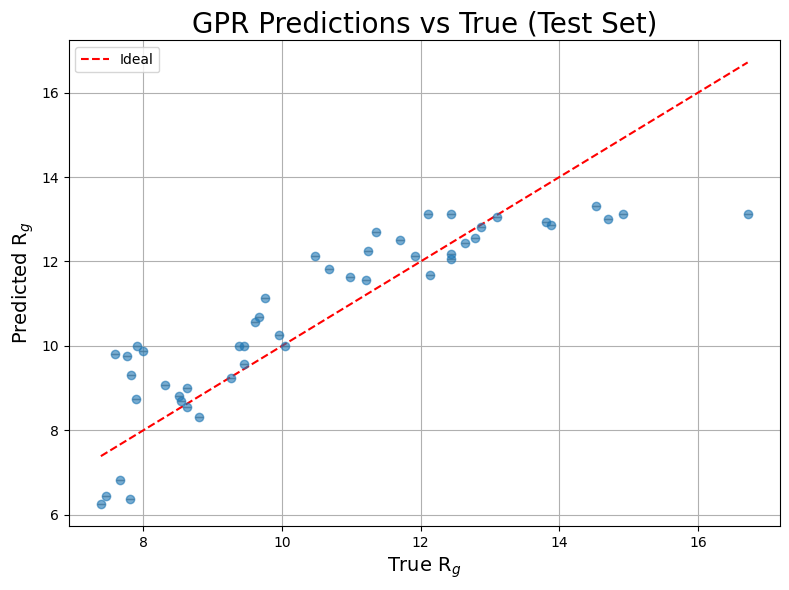

In [ ]:
# ---------- Select and scale test features ----------
pca_columns = [f"PCA_{i}" for i in range(100)]
feature_cols = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']

X_test = df_test[feature_cols]
X_test_scaled = scaler.transform(X_test)  # use the same scaler from training!

y_test = df_test["rg_mean"].values

# ---------- Predict ----------
y_pred_test, y_std_test = gpr.predict(X_test_scaled, return_std=True)

# ---------- Save predictions ----------
results_test = df_test[["Comp", "BID"]].copy()
results_test["rg_true"] = y_test
results_test["rg_pred"] = y_pred_test
results_test["rg_std"] = y_std_test
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, y_pred_test, yerr=y_std_test, fmt='o', alpha=0.6, ecolor='gray', capsize=3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Ideal")
plt.xlabel(fr"True R$_g$", fontsize = 14)
plt.ylabel(fr"Predicted R$_g$", fontsize = 14)
plt.title("GPR Predictions vs True (Test Set)", fontsize = 20)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Anisotropy

In [30]:
#Matern Kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 5, 10)
nus = np.linspace(0.25, 5, 10)
# ---------- Features ----------
# Select features (Comp, BID, UMAP_0, UMAP_1, PCA_0, PCA_1, ..., PCA_99)
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]  # Training input features
X_val = df_val[features]      # Validation input features

# ---------- Scaling ----------
scaler = StandardScaler()

# Apply scaling to both train and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------- Targets ----------
# Now we have only the mean as the target (anis_mean)
# Target
target = "anis_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for nu in nus:
        kernel = Matern(length_scale=length_scale, nu=nu, length_scale_bounds=(1e-3, 1e3))
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
            "Length_scale": length_scale,
            "Nu": nu,
            "MSE": mse
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pr


Best hyperparameters based on MSE:
Length_scale    0.644444
Nu              0.250000
MSE             0.001189
Name: 10, dtype: float64

All results:
    Length_scale        Nu       MSE
0            0.1  0.250000  0.001189
1            0.1  0.777778  0.002141
2            0.1  1.305556  0.004771
3            0.1  1.833333  0.008664
4            0.1  2.361111  0.013871
..           ...       ...       ...
95           5.0  2.888889  0.020189
96           5.0  3.416667  0.026627
97           5.0  3.944444  0.032456
98           5.0  4.472222  0.037447
99           5.0  5.000000  0.041617

[100 rows x 3 columns]


In [16]:
#ExpSineSquared Kernel
# Define the parameter ranges
Length_scales = np.linspace(0.1, 8, 10)
Period = np.linspace(0.1, 5, 10)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "anis_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for period in Period:
        kernel = ExpSineSquared(length_scale, period)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)
        r2 = r2_score(y_val, y_pred_val)

        results.append({
            "Length_scale": length_scale,
            "Periodicity": period,
            "MSE": mse
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)


Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale    7.030000
Periodicity     3.911111
MSE             0.048478
Name: 707, dtype: float64

All results:
      Length_scale  Periodicity       MSE
0              0.1     0.100000  0.073984
1              0.1     0.644444  0.072309
2              0.1     1.188889  0.070804
3              0.1     1.733333  0.056582
4              0.1     2.277778  0.070804
...            ...          ...       ...
1005          10.0     2.822222  0.080129
1006          10.0     3.366667  0.070804
1007          10.0     3.911111  0.070804
1008          10.0     4.455556  0.070804
1009          10.0     5.000000  0.071781

[1010 rows x 3 columns]


In [17]:
#RationalQuadratic kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 10, 21)
alphas = np.linspace(0.1, 10, 21)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "anis_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for alpha in alphas:
        kernel = RationalQuadratic(length_scale, alpha)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)
            
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
                "Length_scale": length_scale,
                "Alpha": alpha,
                "MSE": mse
        })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale    0.595000
Alpha           2.080000
MSE             0.001002
Name: 25, dtype: float64

All results:
     Length_scale   Alpha       MSE
0             0.1   0.100  0.001002
1             0.1   0.595  0.001002
2             0.1   1.090  0.001002
3             0.1   1.585  0.001002
4             0.1   2.080  0.001002
..            ...     ...       ...
436          10.0   8.020  0.001002
437          10.0   8.515  0.001002
438          10.0   9.010  0.001002
439          10.0   9.505  0.001002
440          10.0  10.000  0.001002

[441 rows x 3 columns]


In [18]:
# RBF Kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 10, 101)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "anis_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    kernel = RBF(length_scale)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
    gpr.fit(X_train_scaled, y_train)
    y_pred_val = gpr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
        
    mse = mean_squared_error(y_val, y_pred_val)

    results.append({
            "length_scale": length_scale,
            "MSE": mse
    })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
length_scale    5.347000
MSE             0.070804
Name: 53, dtype: float64

All results:
     length_scale       MSE
0           0.100  0.070804
1           0.199  0.070804
2           0.298  0.070804
3           0.397  0.070804
4           0.496  0.070804
..            ...       ...
96          9.604  0.070804
97          9.703  0.070804
98          9.802  0.070804
99          9.901  0.070804
100        10.000  0.070804

[101 rows x 2 columns]


In [19]:
# Dot product Kernel
# Define the parameter ranges
Sigma = np.linspace(0.1, 15, 151)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "anis_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for sigma in Sigma:
    kernel = DotProduct(sigma)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
    gpr.fit(X_train_scaled, y_train)
    y_pred_val = gpr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
        
    mse = mean_squared_error(y_val, y_pred_val)

    results.append({
            "Sigma": sigma,
            "MSE": mse
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Sigma    8.245333
MSE      0.000887
Name: 82, dtype: float64

All results:
         Sigma       MSE
0     0.100000  0.000978
1     0.199333  0.000923
2     0.298667  0.000923
3     0.398000  0.000923
4     0.497333  0.000923
..         ...       ...
146  14.602667  0.000922
147  14.702000  0.000923
148  14.801333  0.000923
149  14.900667  0.000920
150  15.000000  0.000924

[151 rows x 2 columns]


Acylindricity

In [20]:
#Matern Kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 5, 10)
nus = np.linspace(0.25, 5, 10)
# ---------- Features ----------
# Select features (Comp, BID, UMAP_0, UMAP_1, PCA_0, PCA_1, ..., PCA_99)
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]  # Training input features
X_val = df_val[features]      # Validation input features

# ---------- Scaling ----------
scaler = StandardScaler()

# Apply scaling to both train and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------- Targets ----------
# Now we have only the mean as the target (anis_mean)
# Target
target = "acyl_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for nu in nus:
        kernel = Matern(length_scale=length_scale, nu=nu, length_scale_bounds=(1e-3, 1e3))
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
            "Length_scale": length_scale,
            "Nu": nu,
            "MSE": mse
        })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale     3.911111
Nu               0.250000
MSE             24.618961
Name: 70, dtype: float64

All results:
    Length_scale        Nu         MSE
0            0.1  0.250000   24.618964
1            0.1  0.777778   68.451587
2            0.1  1.305556  127.657408
3            0.1  1.833333  181.297442
4            0.1  2.361111  224.417021
..           ...       ...         ...
95           5.0  2.888889  258.006177
96           5.0  3.416667  283.846446
97           5.0  3.944444  303.832687
98           5.0  4.472222  319.532813
99           5.0  5.000000  332.086608

[100 rows x 3 columns]


In [21]:
#ExpSineSquared Kernel
# Define the parameter ranges
Length_scales = np.linspace(0.1, 8, 10)
Period = np.linspace(0.1, 5, 10)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "acyl_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for period in Period:
        kernel = ExpSineSquared(length_scale, period)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
            "Length_scale": length_scale,
            "Periodicity": period,
            "MSE": mse
        })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)


Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_


Best hyperparameters based on MSE:
Length_scale      0.644444
Periodicity       1.733333
MSE             420.598863
Name: 13, dtype: float64

All results:
    Length_scale  Periodicity         MSE
0            0.1     0.100000  436.373559
1            0.1     0.644444  828.093135
2            0.1     1.188889  436.394781
3            0.1     1.733333  436.387891
4            0.1     2.277778  848.311749
..           ...          ...         ...
95           5.0     2.822222  436.394520
96           5.0     3.366667  436.348565
97           5.0     3.911111  427.506212
98           5.0     4.455556  433.269665
99           5.0     5.000000  848.311749

[100 rows x 3 columns]


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [22]:
#RationalQuadratic kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 10, 21)
alphas = np.linspace(0.1, 10, 21)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "acyl_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for alpha in alphas:
        kernel = RationalQuadratic(length_scale, alpha)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)
            
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
                "Length_scale": length_scale,
                "Alpha": alpha,
                "MSE": mse
        })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale     0.595000
Alpha            7.525000
MSE             30.675727
Name: 36, dtype: float64

All results:
     Length_scale   Alpha        MSE
0             0.1   0.100  30.675729
1             0.1   0.595  30.675729
2             0.1   1.090  30.675729
3             0.1   1.585  30.675729
4             0.1   2.080  30.675730
..            ...     ...        ...
436          10.0   8.020  30.675729
437          10.0   8.515  30.675729
438          10.0   9.010  30.675729
439          10.0   9.505  30.675729
440          10.0  10.000  30.675729

[441 rows x 3 columns]


In [23]:
# RBF Kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 10, 101)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "acyl_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    kernel = RBF(length_scale)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
    gpr.fit(X_train_scaled, y_train)
    y_pred_val = gpr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
        
    mse = mean_squared_error(y_val, y_pred_val)

    results.append({
            "length_scale": length_scale,
            "MSE": mse
    })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre


Best hyperparameters based on MSE:
length_scale      7.723000
MSE             436.394989
Name: 77, dtype: float64

All results:
     length_scale         MSE
0           0.100  436.395061
1           0.199  436.395110
2           0.298  436.395050
3           0.397  436.395049
4           0.496  436.395061
..            ...         ...
96          9.604  436.395082
97          9.703  436.395050
98          9.802  436.395044
99          9.901  436.395048
100        10.000  436.395082

[101 rows x 2 columns]


In [24]:
# Dot product Kernel
# Define the parameter ranges
Sigma = np.linspace(0.1, 15, 151)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "acyl_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for sigma in Sigma:
    kernel = DotProduct(sigma)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
    gpr.fit(X_train_scaled, y_train)
    y_pred_val = gpr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
        
    mse = mean_squared_error(y_val, y_pred_val)

    results.append({
            "Sigma": sigma,
            "MSE": mse
    })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Sigma     6.258667
MSE      32.172680
Name: 62, dtype: float64

All results:
         Sigma        MSE
0     0.100000  34.910198
1     0.199333  34.881377
2     0.298667  37.301065
3     0.398000  34.771162
4     0.497333  40.250632
..         ...        ...
146  14.602667  34.462980
147  14.702000  35.154808
148  14.801333  37.617338
149  14.900667  34.920376
150  15.000000  34.024703

[151 rows x 2 columns]


Asphericity

In [25]:
#Matern Kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 5, 10)
nus = np.linspace(0.25, 5, 10)
# ---------- Features ----------
# Select features (Comp, BID, UMAP_0, UMAP_1, PCA_0, PCA_1, ..., PCA_99)
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]  # Training input features
X_val = df_val[features]      # Validation input features

# ---------- Scaling ----------
scaler = StandardScaler()

# Apply scaling to both train and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ---------- Targets ----------
# Now we have only the mean as the target (anis_mean)
# Target
target = "asph_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for nu in nus:
        kernel = Matern(length_scale=length_scale, nu=nu, length_scale_bounds=(1e-3, 1e3))
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
            "Length_scale": length_scale,
            "Nu": nu,
            "MSE": mse
        })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale      2.822222
Nu                0.250000
MSE             177.874208
Name: 50, dtype: float64

All results:
    Length_scale        Nu          MSE
0            0.1  0.250000   177.874249
1            0.1  0.777778   465.310786
2            0.1  1.305556   835.638163
3            0.1  1.833333  1158.234937
4            0.1  2.361111  1415.927918
..           ...       ...          ...
95           5.0  2.888889  1615.921816
96           5.0  3.416667  1768.202016
97           5.0  3.944444  1884.585705
98           5.0  4.472222  1975.003028
99           5.0  5.000000  2046.675651

[100 rows x 3 columns]


In [26]:
#ExpSineSquared Kernel
# Define the parameter ranges
Length_scales = np.linspace(0.1, 8, 10)
Period = np.linspace(0.1, 5, 10)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "asph_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for period in Period:
        kernel = ExpSineSquared(length_scale, period)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
            "Length_scale": length_scale,
            "Periodicity": period,
            "MSE": mse
        })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and c


Best hyperparameters based on MSE:
Length_scale       1.188889
Periodicity        0.100000
MSE             2539.018027
Name: 20, dtype: float64

All results:
    Length_scale  Periodicity          MSE
0            0.1     0.100000  4500.822538
1            0.1     0.644444  2621.465076
2            0.1     1.188889  2621.511156
3            0.1     1.733333  2621.512455
4            0.1     2.277778  2621.489277
..           ...          ...          ...
95           5.0     2.822222  2621.510500
96           5.0     3.366667  2621.305255
97           5.0     3.911111  2621.485342
98           5.0     4.455556  2621.505428
99           5.0     5.000000  2686.529107

[100 rows x 3 columns]


In [27]:
#RationalQuadratic kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 10, 21)
alphas = np.linspace(0.1, 10, 21)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "asph_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    for alpha in alphas:
        kernel = RationalQuadratic(length_scale, alpha)
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
        gpr.fit(X_train_scaled, y_train)
        y_pred_val = gpr.predict(X_val_scaled)
        mse = mean_squared_error(y_val, y_pred_val)
            
        mse = mean_squared_error(y_val, y_pred_val)

        results.append({
                "Length_scale": length_scale,
                "Alpha": alpha,
                "MSE": mse
        })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Length_scale      0.595000
Alpha            10.000000
MSE             201.179881
Name: 41, dtype: float64

All results:
     Length_scale   Alpha         MSE
0             0.1   0.100  201.179901
1             0.1   0.595  201.179904
2             0.1   1.090  201.179901
3             0.1   1.585  201.179899
4             0.1   2.080  201.179901
..            ...     ...         ...
436          10.0   8.020  201.179901
437          10.0   8.515  201.179903
438          10.0   9.010  201.179902
439          10.0   9.505  201.179902
440          10.0  10.000  201.179904

[441 rows x 3 columns]


In [28]:
# RBF Kernel
# Define the parameter ranges
length_scales = np.linspace(0.1, 10, 101)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "asph_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for length_scale in length_scales:
    kernel = RBF(length_scale)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
    gpr.fit(X_train_scaled, y_train)
    y_pred_val = gpr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
        
    mse = mean_squared_error(y_val, y_pred_val)

    results.append({
            "length_scale": length_scale,
            "MSE": mse
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(



Best hyperparameters based on MSE:
length_scale       4.159000
MSE             2621.511031
Name: 41, dtype: float64

All results:
     length_scale          MSE
0           0.100  2621.511157
1           0.199  2621.511158
2           0.298  2621.511158
3           0.397  2621.511151
4           0.496  2621.511159
..            ...          ...
96          9.604  2621.511159
97          9.703  2621.511159
98          9.802  2621.511158
99          9.901  2621.511157
100        10.000  2621.511045

[101 rows x 2 columns]


In [29]:
# Dot product Kernel
# Define the parameter ranges
Sigma = np.linspace(0.1, 15, 151)

# Scale the features
features = ['Comp', 'BID', 'UMAP_0', 'UMAP_1']
X_train = df_train[features]
X_val = df_val[features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Target
target = "asph_mean"
y_train = df_train[target].values
y_val = df_val[target].values

# Store results
results = []

# Loop over length_scale and nu values
print("Running hyperparameter sweep...")
for sigma in Sigma:
    kernel = DotProduct(sigma)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=20)
        
    gpr.fit(X_train_scaled, y_train)
    y_pred_val = gpr.predict(X_val_scaled)
    mse = mean_squared_error(y_val, y_pred_val)
        
    mse = mean_squared_error(y_val, y_pred_val)

    results.append({
            "Sigma": sigma,
            "MSE": mse
    })


# Convert to DataFrame
results_df = pd.DataFrame(results)

# Show the best parameters
best_params = results_df.loc[results_df["MSE"].idxmin()]
print("\nBest hyperparameters based on MSE:")
print(best_params)

# Print full results
print("\nAll results:")
print(results_df)

Running hyperparameter sweep...


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sc


Best hyperparameters based on MSE:
Sigma      9.934000
MSE      186.704031
Name: 99, dtype: float64

All results:
         Sigma         MSE
0     0.100000  206.509507
1     0.199333  206.969364
2     0.298667  201.222480
3     0.398000  206.201953
4     0.497333  206.024849
..         ...         ...
146  14.602667  213.313647
147  14.702000  206.857075
148  14.801333  216.019479
149  14.900667  207.949957
150  15.000000  212.152012

[151 rows x 2 columns]


c:\Users\pt3594\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\gaussian_process\_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
